<a href="https://colab.research.google.com/github/manasa-rajesh/Dog_Breed_Detection/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manasar08","key":"815fff13ae8a80440464682da38db2fb"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir dog_dataset

In [7]:
%cd dog_dataset

/content/dog_dataset


In [8]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05            209  


In [9]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

 99% 685M/691M [00:12<00:00, 63.6MB/s]
100% 691M/691M [00:12<00:00, 56.3MB/s]


In [10]:
%cd ..

/content


In [27]:
#!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset

In [12]:
!rm dog_dataset/dogbreedidfromcomp.zip

In [13]:
!rm dog_dataset/sample_submission.csv

## Loading Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

## Loading the data

In [15]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
labels_all.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
breeds_all = labels_all['breed']
breeds_all.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [17]:
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


## Preprocessing the data

In [18]:
X_data = np.zeros((len(labels),224,224,3),dtype='float32')
Y_data = label_binarize(labels['breed'], classes=CLASS_NAMES)

In [19]:
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=((224,224)))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x/255.0

100%|██████████| 357/357 [00:01<00:00, 251.05it/s]


In [20]:
X_data.shape, Y_data.shape

((357, 224, 224, 3), (357, 3))

## Model Building

In [21]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation = 'relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation="softmax"))

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        25104     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         3

## Splitting the data

In [24]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)

In [25]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2)

## Training

In [26]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 38s 2s/step - loss: 4.9072 - accuracy: 0.3555 - val_loss: 4.8942 - val_accuracy: 0.3077
Epoch 2/100
2/2 [==============================] - 1s 512ms/step - loss: 4.8801 - accuracy: 0.3594 - val_loss: 4.8708 - val_accuracy: 0.3077
Epoch 3/100
2/2 [==============================] - 1s 507ms/step - loss: 4.8546 - accuracy: 0.3594 - val_loss: 4.8483 - val_accuracy: 0.3077
Epoch 4/100
2/2 [==============================] - 1s 507ms/step - loss: 4.8287 - accuracy: 0.3594 - val_loss: 4.8249 - val_accuracy: 0.3077
Epoch 5/100
2/2 [==============================] - 1s 507ms/step - loss: 4.8030 - accuracy: 0.3594 - val_loss: 4.8018 - val_accuracy: 0.3077
Epoch 6/100
2/2 [==============================] - 1s 528ms/step - loss: 4.7773 - accuracy: 0.3594 - val_loss: 4.7779 - val_accuracy: 0.3077
Epoch 7/100
2/2 [==============================] - 1s 509ms/step - loss: 4.7519 - accuracy: 0.3594 - val_loss: 4.7537 - val_accuracy: 0.3077
Epoch 8/100
2/2

## Testing

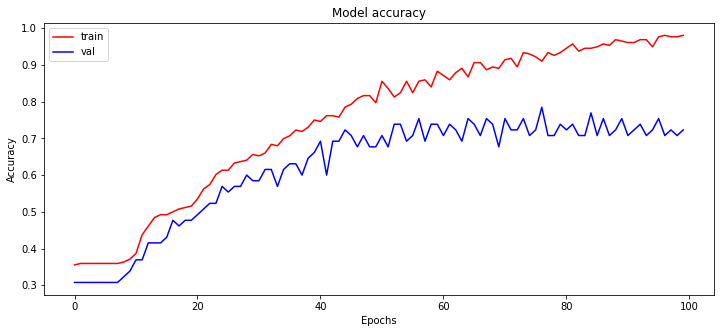

In [29]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [30]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 16ms/step - loss: 3.2286 - accuracy: 0.7222


In [31]:
print("Accuracy: ", round((score[1]*100), 2), '%')

Accuracy:  72.22 %


In [32]:
model.save("dog_breed.h5")